<a   href="https://colab.research.google.com/github/N-Nieto/OHBM_SEA-SIG_Educational_Course/blob/master/01_basic_ML/01_basics_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Basic Machine Learning

##  1. Set up

In [ ]:
# libraries for data analysis
import numpy as np
import pandas as pd
# libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [ ]:
# read the behavioural data

df_behav = pd.read_csv(Path("../data/cleaned_IXI_behavioural.csv"), index_col=0)

# get the imaging data: we will use gray matter volume (GMV) 
# of 100 cortical parcels from the Schaefer 100x17 parcellation
df_GMV = pd.read_csv(Path("../data/cleaned_VBM_GM_Schaefer100x17_mean_aggregation.csv"), index_col=0)
columns_GMV = df_GMV.columns.tolist()

            SEX_ID (1=m, 2=f)  HEIGHT  WEIGHT         DOB  STUDY_DATE  \
subjectID                                                               
sub-IXI002                  2     164      58  1970-01-30  2005-11-18   
sub-IXI012                  1     175      70  1966-08-20  2005-06-01   
sub-IXI013                  1     182      70  1958-09-15  2005-06-01   
sub-IXI014                  2     163      65  1971-03-15  2005-06-09   
sub-IXI015                  1     181      90  1981-03-11  2005-06-23   

                  AGE  LH_VisCent_ExStr_1  LH_VisCent_ExStr_2  \
subjectID                                                       
sub-IXI002  35.800137            0.434407            0.431125   
sub-IXI012  38.781656            0.496368            0.487446   
sub-IXI013  46.710472            0.414027            0.445955   
sub-IXI014  34.236824            0.422764            0.369221   
sub-IXI015  24.284736            0.388491            0.398731   

            LH_VisCent_Striate_1

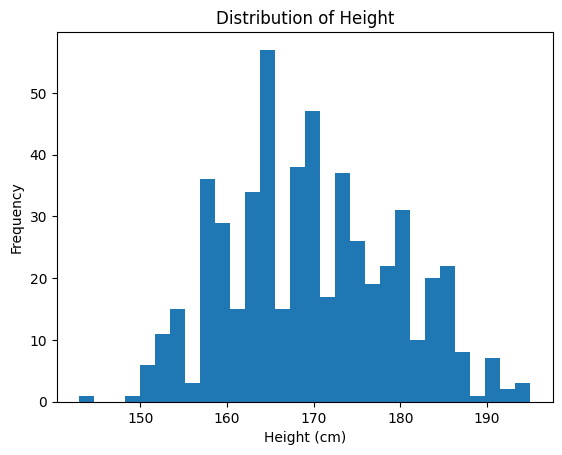

In [5]:
# combine behavioural and GMV data
# as the subject IDs are the index, we can use join
df_data = df_behav.join(df_GMV, how="inner")
print(df_data.head())

# histogram the height (our target variable) as a sanity check
plt.hist(df_data["HEIGHT"], bins=30)
plt.xlabel("Height (cm)")
plt.ylabel("Frequency")
plt.title("Distribution of Height")
plt.show()

## 2. First prediction model

OLS performance (train-test split):
Train: r=0.84, r2=0.71
Test : r=0.51, r2=0.05


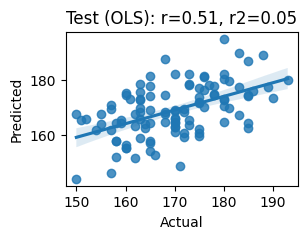

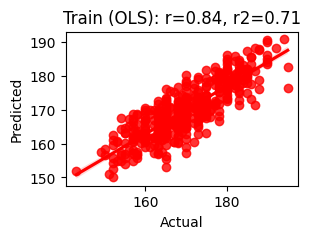

In [6]:
# A model to predict height of a person using their neuroimaging data. 
# features (X): gray matter volume of different brain regions
# target (y): height of a person
# model (h): linear regression, i.e. ordinary least squares (OLS)
from sklearn.linear_model import LinearRegression

# do train-test split to evaluate the model on unseen data
from sklearn.model_selection import train_test_split
# the function resturns dataframes for training and test data
# 80% training, 20% test (passed as test_size=0.2)
# set random_state for reproducibility
train_data, test_data = train_test_split(df_data, test_size=0.2, random_state=1)

# train a OLS regression model
model = LinearRegression()
# fit the model using training data
# we need both features (X) and target (y)
# this is where the model learns the parameters, i.e. weights
model.fit(X=train_data[columns_GMV], y=train_data["HEIGHT"])

# predict test data using the trained model
# we only need features (X)
# the model will predict the target (y)
y_pred = model.predict(X=test_data[columns_GMV])

# evaluate the model: we know the true target values
y_true = test_data["HEIGHT"].values
# get correlation and r2_Score
r = np.corrcoef(y_true, y_pred)[0, 1]
from sklearn.metrics import r2_score
r2 = r2_score(y_true, y_pred)

# also get the training performance
y_train_pred = model.predict(X=train_data[columns_GMV])
y_train_true = train_data["HEIGHT"].values

r_train = np.corrcoef(y_train_true, y_train_pred)[0, 1]
r2_train = r2_score(y_train_true, y_train_pred)

print("OLS performance (train-test split):")
print(f"Train: r={r_train:.2f}, r2={r2_train:.2f}")
print(f"Test : r={r:.2f}, r2={r2:.2f}")

# scatterplot true versus predicted test set values
plt.figure(figsize=(3, 2))
sns.regplot(x=y_true, y=y_pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(f"Test (OLS): r={r:.2f}, r2={r2:.2f}")
plt.show()

# plot the training set performance in red
plt.figure(figsize=(3, 2))
sns.regplot(x=y_train_true, y=y_train_pred, color='red')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(f"Train (OLS): r={r_train:.2f}, r2={r2_train:.2f}")
plt.show()


1. What is the relationship between the training and test performance?
2. What does this tell us about the OLS model?

## 3. Ridge regression: a regularized model

Ridge performance (train-test split):
Train: r=0.73, r2=0.51
Test : r=0.59, r2=0.35


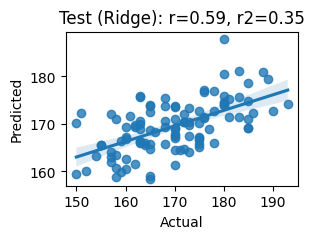

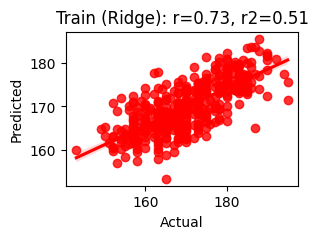

In [7]:
# Can we improve with L2 regularization (Ridge regression)? 
from sklearn.linear_model import Ridge

model = Ridge()
# we already have train-test split from before
model.fit(X=train_data[columns_GMV], y=train_data["HEIGHT"])
y_pred = model.predict(X=test_data[columns_GMV])

r = np.corrcoef(y_true, y_pred)[0, 1]
r2 = r2_score(y_true, y_pred)

# also check training performance
y_train_pred = model.predict(X=train_data[columns_GMV])
r_train = np.corrcoef(y_train_true, y_train_pred)[0, 1]
r2_train = r2_score(y_train_true, y_train_pred)

print("Ridge performance (train-test split):")
print(f"Train: r={r_train:.2f}, r2={r2_train:.2f}")
print(f"Test : r={r:.2f}, r2={r2:.2f}")

# plot
plt.figure(figsize=(3, 2))
sns.regplot(x=y_true, y=y_pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(f"Test (Ridge): r={r:.2f}, r2={r2:.2f}")
plt.show()

# plot the training set performance
plt.figure(figsize=(3, 2))
sns.regplot(x=y_train_true, y=y_train_pred, color='red')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(f"Train (Ridge): r={r_train:.2f}, r2={r2_train:.2f}")
plt.show()

1. Why did the performance improve compared to OLS?
2. Is the test performance always lower than the train performance?

## 4. k-fold cross-validation

Fold 1: r = 0.589, r2 = 0.345


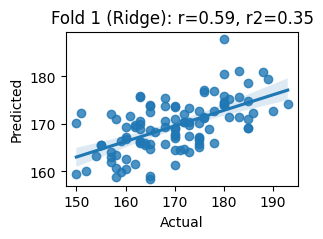

Fold 2: r = 0.579, r2 = 0.317


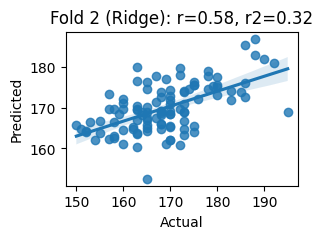

Fold 3: r = 0.612, r2 = 0.369


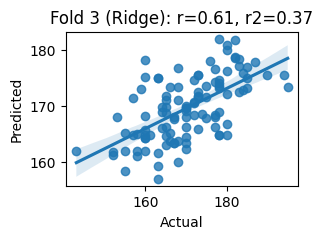

Fold 4: r = 0.547, r2 = 0.283


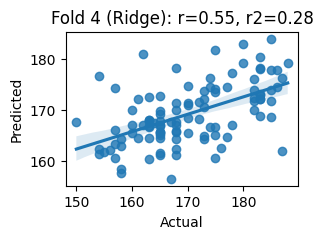

Fold 5: r = 0.624, r2 = 0.376


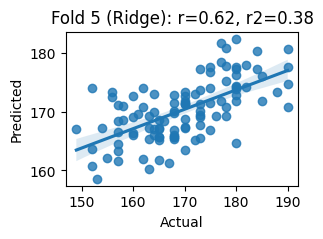

Ridge performance (k-fold CV):
Train: r = 0.728, r2 = 0.513
Test : r = 0.590, r2 = 0.338


In [50]:
# k-fold cross-validation: more efficient use of data
# we will use 5-fold cross-validation
from sklearn.model_selection import KFold

# Set up
outer_cv = KFold(n_splits=5, shuffle=True, random_state=1)

# Store results
test_r_scores = []
test_r2_scores = []
train_r_scores = []
train_r2_scores = []

for fold, (train_index, test_index) in enumerate(outer_cv.split(df_data)):
    # calling split on the KFold object returns 
    # indices for train and test sets
    # use iloc to get the actual dataframes
    train_data = df_data.iloc[train_index]
    test_data = df_data.iloc[test_index]

    # Train Ridge model
    model = Ridge()
    model.fit(train_data[columns_GMV], train_data["HEIGHT"])

    # Predict
    y_pred = model.predict(test_data[columns_GMV])
    y_true = test_data["HEIGHT"].values

    # Evaluate
    test_r = np.corrcoef(y_true, y_pred)[0, 1]
    test_r2 = r2_score(y_true, y_pred)
    test_r_scores.append(test_r)
    test_r2_scores.append(test_r2)

    print(f"Fold {fold + 1}: r = {test_r:.3f}, r2 = {test_r2:.3f}")
    # plot fold-wise performance
    plt.figure(figsize=(3, 2))
    sns.regplot(x=y_true, y=y_pred)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"Fold {fold + 1} (Ridge): r={test_r:.2f}, r2={test_r2:.2f}")
    plt.show()

    # Evaluate on the training data as well (do we overfit?)
    y_train_pred = model.predict(train_data[columns_GMV])
    y_train_true = train_data["HEIGHT"].values
    train_r = np.corrcoef(y_train_true, y_train_pred)[0, 1]
    train_r2 = r2_score(y_train_true, y_train_pred)
    train_r_scores.append(train_r)
    train_r2_scores.append(train_r2)

# Print performance
print('Ridge performance (k-fold CV):')
print(f"Train: r = {np.mean(train_r_scores):.3f}, r2 = {np.mean(train_r2_scores):.3f}")
print(f"Test : r = {np.mean(test_r_scores):.3f}, r2 = {np.mean(test_r2_scores):.3f}")




 Oh but we have one hyperparameter for Ridge:
 
`alpha{float, ndarray of shape (n_targets,)}, default=1.0
    Constant that multiplies the L2 term, controlling regularization strength. alpha must be a non-negative float i.e. in [0, inf).`

How to choose it?
Nested cross-validation!

## 5. Nested cross-validation

In [51]:
from sklearn.model_selection import GridSearchCV

# define alpha values to tests
alphas = [0.01, 0.1, 0.5, 1.0, 10.0]
print("Optimizing alpha values using nested CV")

# Set up
outer_cv = KFold(n_splits=5, shuffle=True, random_state=1)

# Store results
test_r_scores = []
test_r2_scores = []
train_r_scores = []
train_r2_scores = []
best_alphas = []

# outer CV loop
# here we will do "model evaluation"
for fold, (train_index, test_index) in enumerate(outer_cv.split(df_data)):
    train_data = df_data.iloc[train_index]
    test_data = df_data.iloc[test_index]

    # Train Ridge model while optimizing alpha in a for loop
    inner_score_max = -np.inf
    best_alpha = None
    for alpha in alphas:
        # new for loop to test for each alpha
        # we will do an inner cross-validation to find the best alpha
        # for each alpha, we will do a 5-fold cross-validation on the training data
        inner_cv = KFold(n_splits=5, shuffle=True, random_state=10)
        inner_scores = []
        # inner CV loop
        # here we will do "model selection"
        for train_index_inner, test_index_inner in inner_cv.split(train_data):
            train_data_inner = train_data.iloc[train_index_inner]
            test_data_inner = train_data.iloc[test_index_inner]
            model = Ridge(alpha=alpha)
            model.fit(train_data_inner[columns_GMV], train_data_inner["HEIGHT"])
            inner_scores.append(
                model.score(test_data_inner[columns_GMV], test_data_inner["HEIGHT"])
            )
        mean_inner_score = np.mean(inner_scores)
        # check if this is the best alpha so far
        if mean_inner_score > inner_score_max:
            inner_score_max = mean_inner_score
            best_alpha = alpha

    # fit model with best alpha found in inner loop
    # use the entire training data
    best_alphas.append(best_alpha)
    model = Ridge(alpha=best_alpha)
    model.fit(train_data[columns_GMV], train_data["HEIGHT"])

    # Predict
    y_pred = model.predict(test_data[columns_GMV])
    y_true = test_data["HEIGHT"].values    

    # Evaluate
    test_r = np.corrcoef(y_true, y_pred)[0, 1]
    test_r2 = r2_score(y_true, y_pred)
    test_r_scores.append(test_r)
    test_r2_scores.append(test_r2)

    print(
        f"Fold {fold + 1}: r = {test_r:.3f}, r2 = {test_r2:.3f}, alpha = {best_alpha}"
    )

    # Evaluate on the training data as well (do we overfit?)
    y_train_pred = model.predict(train_data[columns_GMV])
    y_train_true = train_data["HEIGHT"].values
    train_r = np.corrcoef(y_train_true, y_train_pred)[0, 1]
    train_r2 = r2_score(y_train_true, y_train_pred)
    train_r_scores.append(train_r)
    train_r2_scores.append(train_r2)

print('Ridge performance (k-fold CV):')
print(f"Train: r = {np.mean(train_r_scores):.3f}, r2 = {np.mean(train_r2_scores):.3f}")
print(f"Test : r = {np.mean(test_r_scores):.3f}, r2 = {np.mean(test_r2_scores):.3f}")


Optimizing alpha values using nested CV
Fold 1: r = 0.589, r2 = 0.345, alpha = 1.0
Fold 2: r = 0.579, r2 = 0.317, alpha = 1.0
Fold 3: r = 0.612, r2 = 0.369, alpha = 1.0
Fold 4: r = 0.547, r2 = 0.283, alpha = 1.0
Fold 5: r = 0.624, r2 = 0.376, alpha = 1.0
Ridge performance (k-fold CV):
Train: r = 0.728, r2 = 0.513
Test : r = 0.590, r2 = 0.338


1. What is the difference between train-test split and k-fold CV?
2. What is the purpose of hyperparameter tuning?
3. What is the difference between hyperparameters and parameters?
4. What to do if the selected hyperparameter is at the edge of the search space?

## 6. Using scikit-learn's GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV

# define the grid search for alpha values
# notice here we define a dictionary
# the key is the hyperparameter name of the model
# the value is a list of values to test
param_grid = {"alpha": [0.01, 0.1, 0.5, 1.0, 10.0]}
print("Optimizing alpha values using grid search")

# Set up
outer_cv = KFold(n_splits=5, shuffle=True, random_state=1)

# Store results
r_list = []
r2_list = []
best_alphas = []

for fold, (train_index, test_index) in enumerate(outer_cv.split(df_data)):
    train_data = df_data.iloc[train_index]
    test_data = df_data.iloc[test_index]

    # Find best alpha using GridSearchCV instead of for loop
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=10)
    # define the model as a GridSearchCV object
    model = GridSearchCV(
        Ridge(), param_grid, cv=inner_cv, scoring="r2"
    )  # r2 uses r2_score
    # fit will find the best alpha: it will do the inner cross-validation
    model.fit(train_data[columns_GMV], train_data["HEIGHT"])

    # predicting using this model it will use 
    # the "best" alpha, let's look at that value
    best_alpha = model.best_params_["alpha"]
    best_alphas.append(best_alpha)

    # Predict using the best alpha
    y_pred = model.predict(test_data[columns_GMV])
    y_true = test_data["HEIGHT"].values

    # Evaluate
    r = np.corrcoef(y_true, y_pred)[0, 1]
    r2 = r2_score(y_true, y_pred)
    r_list.append(r)
    r2_list.append(r2)

    print(f"Fold {fold + 1}: r = {r:.3f}, r2 = {r2:.3f}, alpha = {best_alpha}")


Optimizing alpha values using grid search
Fold 1: r = 0.589, r2 = 0.345, alpha = 1.0
Fold 2: r = 0.579, r2 = 0.317, alpha = 1.0
Fold 3: r = 0.612, r2 = 0.369, alpha = 1.0
Fold 4: r = 0.547, r2 = 0.283, alpha = 1.0
Fold 5: r = 0.624, r2 = 0.376, alpha = 1.0


1. Are the results the same as in the previous section?
2. Why/why not?
3. What is the advantage of using GridSearchCV?
4. There is a `cross_val_score` function in sklearn which will remove the outer loop. We do not use it here because we want to learn the concepts of hyperparameter tuning and model selection in more detail.

## 7. Classification

In [ ]:
# let's move to classification

# first create discrete labels for height
# using median height as cutoff
# according to NHS mean height for men is 175 and for women is 162
# let's take average of these two values as cutoff
height_cutoff = (175 + 162) / 2
print(f"Height cutoff: {height_cutoff} cm")

# create a new column in df for tall (1) and short (0)
df_data["TALL"] = (df_data["HEIGHT"] >= height_cutoff).astype(int)
df_data["TALL"].value_counts()

Height cutoff: 168.5 cm


TALL
1    272
0    261
Name: count, dtype: int64

1. Do the classes look balanced? Why is this important? 

In [55]:
# classification needs different models and metrics
# we will use RidgeClassifier and accuracy and ROC AUC as metrics
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

# define the grid search for alhpa values
param_grid = {"alpha": [0.01, 0.1, 0.5, 1.0, 10.0]}

# Set up CV
outer_cv = KFold(n_splits=5, shuffle=True, random_state=1)

# Store results
test_accuracies = []
test_roc_aucs = []
train_accuracies = []
train_roc_aucs = []
best_alphas = []

for fold, (train_index, test_index) in enumerate(outer_cv.split(df_data)):
    train_data = df_data.iloc[train_index]
    test_data = df_data.iloc[test_index]

    # Train Ridge model: now using GridSearchCV instead of for loop
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=10)

    model = GridSearchCV(
        RidgeClassifier(), param_grid, cv=inner_cv, scoring="accuracy"
    )  # accuracy for classification
    model.fit(train_data[columns_GMV], train_data["TALL"])
    # when we predict using this model it will use the "best" alpha value, let's save that value
    best_alpha = model.best_params_["alpha"]
    best_alphas.append(best_alpha)

    # Predict
    y_pred = model.predict(test_data[columns_GMV])
    y_true = test_data["TALL"].values

    # Evaluate
    test_acc = accuracy_score(y_true, y_pred)
    test_roc_auc = roc_auc_score(y_true, y_pred)
    test_accuracies.append(test_acc)
    test_roc_aucs.append(test_roc_auc)

    print(
        f"Fold {fold + 1}: acc = {test_acc:.3f}, ROC AUC = {test_roc_auc:.3f}, alpha = {best_alpha}"
    )

    # Evaluate on the training data as well (do we overfit?)
    y_train_pred = model.predict(train_data[columns_GMV])
    y_train_true = train_data["TALL"].values
    train_acc = accuracy_score(y_train_true, y_train_pred)
    train_roc_auc = roc_auc_score(y_train_true, y_train_pred)
    train_accuracies.append(train_acc)
    train_roc_aucs.append(train_roc_auc)


# print mean accuracy
print('Ridge classifier performance (k-fold CV):')
print(
    f"Train: acc={np.mean(train_accuracies):.3f}, ROC AUC={np.mean(train_roc_aucs):.3f}"
)
print(
    f"Test : acc={np.mean(test_accuracies):.3f}, ROC AUC={np.mean(test_roc_aucs):.3f}"
)

Fold 1: acc = 0.673, ROC AUC = 0.675, alpha = 10.0
Fold 2: acc = 0.664, ROC AUC = 0.665, alpha = 10.0
Fold 3: acc = 0.673, ROC AUC = 0.675, alpha = 10.0
Fold 4: acc = 0.745, ROC AUC = 0.744, alpha = 1.0
Fold 5: acc = 0.755, ROC AUC = 0.754, alpha = 1.0
Ridge classifier performance (k-fold CV):
Train: acc=0.773, ROC AUC=0.773
Test : acc=0.702, ROC AUC=0.702


## 8. Data preprocessing using a `Pipeline`

In [ ]:
# we can also scale the data before classification
# use sklearn's pipeline for that 
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Define the pipeline
# new code
pipeline = Pipeline([("scaler", StandardScaler()), ("ridge", RidgeClassifier())])

# define the grid search for alpha values
# note the change in the key name to match the pipeline step
param_grid = {
    "ridge__alpha": [0.01, 0.1, 0.5, 1.0, 10.0]
}
print("Optimizing alpha values using grid search")

# Set up
outer_cv = KFold(n_splits=5, shuffle=True, random_state=1)

# Store results
test_accuracies = []
test_roc_aucs = []
train_accuracies = []
train_roc_aucs = []
best_alphas = []

for fold, (train_index, test_index) in enumerate(outer_cv.split(df_data)):
    train_data = df_data.iloc[train_index]
    test_data = df_data.iloc[test_index]

    # Train Ridge model: now using GridSearchCV instead of for loop
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=10)

    # Use a pipeline to scale the data before classification
    # scaling becomes part of the model
    # scaling parameters are estimated from the training data only
    # no data leakage!
    model = GridSearchCV(
        pipeline, param_grid, cv=inner_cv, scoring="accuracy"
    )  # accuracy for classification
    model.fit(train_data[columns_GMV], train_data["TALL"])
    # when we predict using this model it will use the "best" alpha value, let's save that value
    best_alpha = model.best_params_["ridge__alpha"]
    best_alphas.append(best_alpha)

    # Predict
    y_pred = model.predict(test_data[columns_GMV])
    y_true = test_data["TALL"].values

    # Evaluate
    test_acc = accuracy_score(y_true, y_pred)
    test_roc_auc = roc_auc_score(y_true, y_pred)
    test_accuracies.append(test_acc)
    test_roc_aucs.append(test_roc_auc)

    print(
        f"Fold {fold + 1}: accuracy = {test_acc:.3f}, roc_auc = {test_roc_auc:.3f}, alpha = {best_alpha}"
    )

    # Evaluate on the training data as well (do we overfit?)
    y_train_pred = model.predict(train_data[columns_GMV])
    y_train_true = train_data["TALL"].values
    train_acc = accuracy_score(y_train_true, y_train_pred)
    train_roc_auc = roc_auc_score(y_train_true, y_train_pred)
    train_accuracies.append(train_acc)
    train_roc_aucs.append(train_roc_auc)


# print mean accuracy
print('Performance:')
print(
    f"Train: acc={np.mean(train_accuracies):.3f}, ROC AUC={np.mean(train_roc_aucs):.3f}"
)
print(
    f"Test : acc={np.mean(test_accuracies):.3f}, ROC AUC={np.mean(test_roc_aucs):.3f}"
)

Optimizing alpha values using grid search
Fold 1: accuracy = 0.570, roc_auc = 0.573, alpha = 10.0
Fold 2: accuracy = 0.654, roc_auc = 0.650, alpha = 10.0
Fold 3: accuracy = 0.673, roc_auc = 0.675, alpha = 10.0
Fold 4: accuracy = 0.623, roc_auc = 0.622, alpha = 10.0
Fold 5: accuracy = 0.717, roc_auc = 0.715, alpha = 10.0
Performance:
Train: acc=0.900, ROC AUC=0.900
Test : acc=0.647, ROC AUC=0.647


1. What will you use as key for `alpha` `param_grid` values if the classifier step in the pipeline is named `clf`?
2. Which preprocessing steps would you add to the pipeline?
3. Why is it important to include preprocessing steps in the pipeline when performing cross-validation?
4. Can all classifiers give ROC AUC scores? Why/why not? 